# Explainers Notebook

In [1]:
# imports used for python code
import networkx as nx
from wordcloud import WordCloud
from PIL import Image
from colour import Color
import pandas as pd
import re
import numpy as np
import io
import nltk
import json

%matplotlib inline
from fa2 import ForceAtlas2
import matplotlib
import matplotlib.pyplot as plt
from community import community_louvain
import random

import urllib2
import csv
import os

 ## Motivation 

### What is your dataset?

The data we decided to use for our analysis, contains the Star Wars Movie scripts for all of the episodes (1-8) and the transcripts for the original triology (4-6). In addition to this we have also downloaded all of the Wookiepedia pages for the charcters who are part of the canonical story. This means the characters from the 8 main movies (Episode 1-8), the two stand alone movies (Rogue One and Solo a Star Wars Story) and the two animated series (The Clones Wars and Rebels). This ends up being a total of 407 Wookiepedia articles. The total size of the data is 12.8 MB.
    

### Why did you choose this/these particular dataset(s)?

We decided on using these two datasets because they hold all the information we need to get out the information we want. The transcript we choose as they hold all the information given in the movies, which is what most casual Star Wars fans only has knowledge of. These are good for analysing sentiments and other stuff.
However, it is very difficult to get any sort of relation between the characters out of the scripts therefore we decided to also download the Wookiepedia articles, as these through the use of hyperlinks will tell us how the characters are connected, according to the fans writing these articles. Also from the Wookiepedia articles we also get some extra data about characters such as race and affiliations, which might not be available through the transcripts.
    
### What was your goal for the end user's experience?

The goal of the project to get a insight to the universe which might not be obvious to the average fan, through analyzing communities, sentiments and nodedegrees. Hopefully we will be able to get some knowledge which will enlighten and educate the user in how the universe is actually working.

## The Dataset
 
### Data cleaning and preprocessing

As our data consist of two sets, we will first explain how we got and preprocessed the movie transcripts, and afterwards for the Wookiepedia articles.

The movietranscripts and dialogue come from multiple sources, [IMSDb](https://www.imsdb.com), [Kaggle](https://www.kaggle.com/xvivancos/analyzing-star-wars-movie-scripts/data) and the [Transcripts wiki](http://transcripts.wikia.com/wiki/Transcripts_Wiki). This is due to none of them having all of the necessary data at the time of writing. 

The dialogues is available for episode IV, V and VI and is stored in .txt with the index of line, the speaker and the dialogue itself. As preprocessing we used regular expressions '''"(.*)" "(.*)" "(.*)"''' to load the lines into a dict, using the charactername as key and their lines in a list as value. Furthermore, we had to manually assess the characternames, as some characters was noted with multiple names throughout the dialogue and typos in the source material was present. The scripts from IMSDB we first downloaded as HTML files, and then removed all of the HTML code to only get the script text. This was done using regular expressions. The scripts we found on the transcripts wiki, has been downloaded as other wiki data through the use of an API. The scriptdata have not been through further prepocessing before usage.

For the Wookieepedia pages we first had to get a list of all the canonical characters. Unfortunately Wookieepedia does not have such a list, and we had to find it on the Wikipedia page for [List of Star Wars characters](https://en.wikipedia.org/wiki/List_of_Star_Wars_characters). This however posed a few unexpected challenges. First of all we downloaded the page through the use of the wikipedia API. Most of the characters names was the written in a set of brackets like {{visible anchor | name}}. This made it fairly easy to the names by using some regular expressions. However not all of the names in the list are the same as the names used on Wookieepedia. This meant we had to remove titles such as Admiral, or only use the first or last name of a character. This however resulted in us getting too many names, as some of the last names of characters, like (Jabba the) Hutt, is the name of a species and therefore has its own Wookieepedia page. These we ended up removing manually. The last hurdle when working with the Wikipedia page, was that two character names did not follow the earlier mentioned structure, meaning we had to add these manually as well. These two where Anakin Skywalker and Darth Sidious, which are rather important for the network. In the end we ended up with 407 names, which have all been saved in a CSV file for convinence. 

In addition to the names we also add the race of the characters and their "goodness" in the CSV file. The race was found on the Wookieepedia page, and the goodness score is calculated on a scale based on which affiliations the characters have on their pages. An evil affiliation will count as -1 and a good affiliation counts as +1. Affiliations being good or evil is based on whether they are connected to the Sith (evil) or the Jedi(good). Below the code used for preprosesing can be seen :

In [ ]:
# Function for fetching list of Star Wars characters from the Wikipedia page
def fetch_characters():
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = "titles=List_of_Star_Wars_characters"
    content = "prop=revisions"
    rvprop ="rvprop=timestamp|content"
    dataformat = "format=json"
    rvdir = "rvdir=older" #sort revisions from newest to oldest
    end = "rvend=2000-01-03T00:00:00Z" #start of my time period
    start = "rvstart=2019-01-03T00:00:00Z" #end of my time period
    limit = "rvlimit=1" #consider only the first revision

    query = "%s%s&%s&%s&%s&%s&%s&%s&%s&%s" % \
    (baseurl, action, title, content, rvprop, dataformat, rvdir, end, start, limit)
    response = urllib2.urlopen(query)
    wikisource = response.read()
    wikijson = json.loads(wikisource)
    wikiid = wikijson["query"]["pages"].keys()[0]
    text = wikijson["query"]["pages"][wikiid]["revisions"][-1]["*"]
    # All characters on this page match the regex below
    regex = "\{\{visible anchor\|(.*?)\}\}"
    chars = re.findall(regex,text)
    characters = []
    for c in chars :
        for s in c.split("|") :
            st = ((s.replace("[", "")).replace("]","")).replace(" ","_")
            # some prefix/suffix fixes
            if (st.startswith("Admiral_")):
                st = st[8:]
            st = st.replace("_(Star_Wars)", "")
            characters.append(st)   
    # Anakin skywalker and Darth Sidious is a special case
    characters.append("Anakin_Skywalker")
    characters.append("Darth_Sidious")
    return set(characters)

# Function for fetching Wookieepedia article from name
def fetch_wiki_article(title_):
    baseurl = "http://starwars.wikia.com/api.php?"
    action = "action=query"
    title = "titles=" + title_ + "&&redirects" # Redirects are gods gift to man
    title = title.encode("utf-8") # This is our fix for unicode problems
    content = "prop=revisions"
    rvprop ="rvprop=timestamp|content"
    dataformat = "format=json"
    rvdir = "rvdir=older" #sort revisions from newest to oldest
    end = "rvend=2000-01-03T00:00:00Z" #start of my time period
    start = "rvstart=2019-01-03T00:00:00Z" #end of my time period
    limit = "rvlimit=1" #consider only the first revision

    query = "%s%s&%s&%s&%s&%s&%s&%s&%s&%s" % \
    (baseurl, action, title, content, rvprop, dataformat, rvdir, end, start, limit)
    response = urllib2.urlopen(query)
    wikisource = response.read()
    wikijson = json.loads(wikisource)
    wikiid = wikijson["query"]["pages"].keys()[0]
    title = wikijson["query"]["pages"][wikiid]["title"]
    text = None
    # Below is equivalent to check if page exists
    if wikiid != "-1" :
        text = wikijson["query"]["pages"][wikiid]["revisions"][-1]["*"]
    # Legends is the comic books of starwars, which is sometimes redirected to.
    # we don't want the characters from that
    if title.endswith("/Legends"): 
        title = title.replace("/Legends", "").replace(" ", "_")
        return fetch_wiki_article(title) 
    return wikiid, text, title



Downloading and storing all data. Fixing the missing and wrong characters manually

In [ ]:
# Function for adding data to character dicrectory
def addToDict(character):
    wiki_id, text, wiki_title = fetch_wiki_article(character)
    if wiki_id == "-1":
        return False
    if wiki_id not in wiki_ids:
        wiki_ids.add(wiki_id)
        # Add the wookiepedia title as key and not the character name from wiki
        charDict[wiki_title] = text
    return True

# Creation of character directory
charDict = {}
characters = fetch_characters()
wiki_ids = set()
leftovers = []
for c in characters:
    if not addToDict(c):
        leftovers.append(c)
        
        
# MANUAL ADDITION AND DELETION OF CHARACTERS        
# Cleaning up leftover characters. 

# Try right side of all leftover characters separated by "_", since a lot of them starts with some random prefix
fixed_leftovers = []
for character in leftovers:
    char = character.split("_")[-1]
    if not addToDict(char):
        fixed_leftovers.append(character)


manual_fixes = ["Tallissan_Lintra", "Aiolin_Astarte", "Morit_Astarte", "CC-2224", 
               "Garazeb_Orrelios", "Kaydel_Ko_Connix", "Dooku", "Weequay", "Orrimaarko", "Rinnrivin_Di",
               "CC-3714", "Temmin_Wexley", "RA-7_protocol_droid", "Breha_Organa", "Saelt-Marae",
                "The_Grand_Inquisitor", "Kaplan_(colonel)"]
for character in manual_fixes:
    addToDict(character)

to_delete = ["Hammerhead", "Velus", "Star Wars: Doctor Aphra", "Kaplan", "Hutt", "Bail Prestor Organa",
            "Teedo", "Karina the Great", "Grand Inquisitor", "Fulcrum", "Weequay", "Senator Organa", "Tup",
            "Rogue Squadron", "Emperor's Royal Guard"]

for char in to_delete:
    del charDict[char]        

Finding "goodness" score for all characters

In [ ]:
# Rating listed affiliation : Good = 1, Evil = -1. All affiliations not listed counted as neutral
affil_dict = {}
affil_dict["Galactic Empire"] = -1
affil_dict["Galactic Republic"] = 1
affil_dict["Alliance to Restore the Republic"] = 1
affil_dict["Confederacy of Independent Systems"] = -1
affil_dict["First Order"] = -1
affil_dict["Resistance"] = 1
affil_dict["New Republic"] = 1
affil_dict["Trade Federation"] = -1
affil_dict["Sith"] = -1
affil_dict["Jedi Order"] = 1
affil_dict["Crimson Dawn"] = -1
affil_dict["Cloud-Riders"] = 1

# Finding affiliations on Wookieepedia pages for all characters
char_affil_dict = {}
for char, text in charDict.items():
    affiliation_section = re.findall("affiliation=[\S\s]*?\}\}\n", text)
    affiliations = re.findall('\[\[(.*?)\]\]', affiliation_section[0])
    for affiliation in affiliations:
        for affil in affiliation.split("|"):
            if affil in affil_dict:
                if char in char_affil_dict:
                    char_affil_dict[char].append(affil)
                else:
                    char_affil_dict[char] = [affil]

char_goodness_dict = {}
# Calculating goodness scores
for char, text in charDict.items():
    goodness = 0
    if char in char_affil_dict:
        affils = char_affil_dict[char]
        for affil in affils:
            goodness += affil_dict[affil]
    char_goodness_dict[char] = goodness

Finding the species for all characters

In [ ]:
# Extracting race data from Wookieepedia articles
char_species_dict = {}
remaining = []
for char, text in charDict.items():
    species = re.findall("species=\*?\[\[(.*?)\]\]", text)
    robot_class = re.findall("class=\*?\[\[(.*?)\]\]", text)
    if species:
        species = species[0].lower()
        if "|" in species:
            species = species.split("|")[1]
            species = "yoda's species"
        char_species_dict[char] = species
    elif robot_class:
        robot_class = robot_class[0].lower()
        robot_class = robot_class.split("|")[0]
        char_species_dict[char] = robot_class
    else:
        remaining.append(char)

# Manual corrections:
char_species_dict["Maz Kanata"] = "humanoid"
char_species_dict["Tasu Leech"] = "human"
char_species_dict["Bendu"] = "unknown"
char_species_dict["Gallius Rax"] = "human"
char_species_dict["L3-37"] = "pilot droid"
char_species_dict["WAC-47"] = "pit droid"
char_species_dict["Sixth Brother"] = "human"
char_species_dict["Cylo"] = "humanoid"
char_species_dict["Jaxxon"] = "rabbit"
char_species_dict["Fifth Brother"] = "humanoid"
char_species_dict["Yaddle"] = "yoda's species"

Saving data to disk

In [ ]:
# Creating CVS file containing Name, Wookiepedia link, Species and Goodness Score
with open('starwarscharacters.csv', 'w+') as csvfile:
    fieldnames = ['name','wookieepedia_name', 'species', 'goodness']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for name in charDict.keys() :
        wookieename = name.replace(" ", "_")
        newName = name.split("/")[0]
        writer.writerow({'name': newName.encode("utf-8"),
                         'wookieepedia_name': wookieename.encode("utf-8"),
                         'species' : char_species_dict[name], 'goodness' : char_goodness_dict[name]})
        
# Saving all Wookieepedia articles on disk
for name, text in charDict.items():
    fileName = name.replace(" ", "_")
    fileName = fileName.split("/")[0]
    f = open("./Wookiepediafiles/" + fileName + ".txt", "w+")
    f.write(text.encode("utf-8"))
    f.close()

### Dataset stats

So in total we ended up with a CSV file containing 407 rows and four columns (Name, Wookieepedia link, Race and Goodness), 407 Wookiepedia articles and 8 movies transcripts. This totaled up to 12.8 MB of data. 

 ## Tools, theory and analysis
 
     Talk about how you've worked with text, including regular expressions, unicode, etc.
 
     Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.
     
    How did you use the tools to understand your dataset?

 
### Overall idea
 
We want to create a network over the characters and their connections. This graph will contain the character names as nodes and the edges between them will be the hyperlinks from the Wookieepedia articles. Where an edge from one node to another means that that characters links to the other. From the network we wish to analyze the centrality measures to get an idea of which characters are important. We also want to find communities in the network and see how these fit up with the known alliances, races or movies. In addition to this we also wish to use the Wookieepedia articles to make a sentiment analysis to see if there is a race which we can consider to be more happy than the others, and which is the most negative.

The movie transcript will be used for sentiment analysis, to try to see if we can detect certain scenes in the movies and see how the mood changes over a single movie or all of the movies. We also wish to see how the mood for individual characters change over a single movie or multiple movies.  
 

 

### Analysis step 1 : The Network
 
#### Explain what you're interested in
     
Interested in creating a network over the characters, to analyze connections to see who is the most important person, analyze communities to see if these follow any grouping of the actual connection such as race, movie, alliance, family or other. And we wish to find which race is the most happy, based on the content of the Wookiepeedia artclies for the characters of each race.

To create the network we will create a directed graph, where we will first create a node for each of the characters from our CSV file. As attributes each node will get their race and goodness. Then we will load each file one by one and add an edge from a node to another node if the corresponding Wookieepedia file from the first node contains a hyperlink to the other node. The way we get the links is by using regular expressions as all of the links are trapped between two set of square brackets, with the link match the name of the character. 

We will then draw the graph using the ForceAtlas library, with the nodes sizes according to their degree, and colored accoring to their goodness score from evil (red) to good (green).


In [2]:
# Loading in the character data
df = pd.read_csv('starwarscharacters.csv')

# Creating the directed graph for the network
G = nx.DiGraph()

# Adding the nodes
for i in range(len(df)):
    name = df.loc[i]['name']
    species = df.loc[i]['species']
    goodness = df.loc[i]['goodness']
    G.add_node(name, goodness=goodness, species=species)
    
# Adding the edges
for i in range(len(df)):
    name = df.loc[i]['name']
    
    # Loading the Wookieepedia text
    fileName = name.replace(" ", "_") + ".txt"
    text = open("./Wookiepediafiles/" + fileName, "r").read()
    
    # Finding the links in the Wookieepedia article and adding them as edges
    links = re.findall('\[\[(.*?)\]\]', text)
    for link in links:
        for l in link.split("|"):
            if l in list(df['name']):
                if not G.has_edge(name, l):
                    G.add_edge(name, l)
                break

                

In [3]:
# Set up forceatlas2 parameters
G_undir = G.to_undirected()

forceatlas2 = ForceAtlas2(# Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,
                          adjustSizes=False,
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=False,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=1.0,
                          strongGravityMode=False,
                          gravity=100.0,
                          # Log
                          verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(G_undir, pos=None, iterations=10000)

100%|██████████| 10000/10000 [00:06<00:00, 1594.20it/s]

('Repulsion forces', ' took ', '3.23', ' seconds')
('Gravitational forces', ' took ', '0.14', ' seconds')
('Attraction forces', ' took ', '0.28', ' seconds')
('AdjustSpeedAndApplyForces step', ' took ', '0.74', ' seconds')


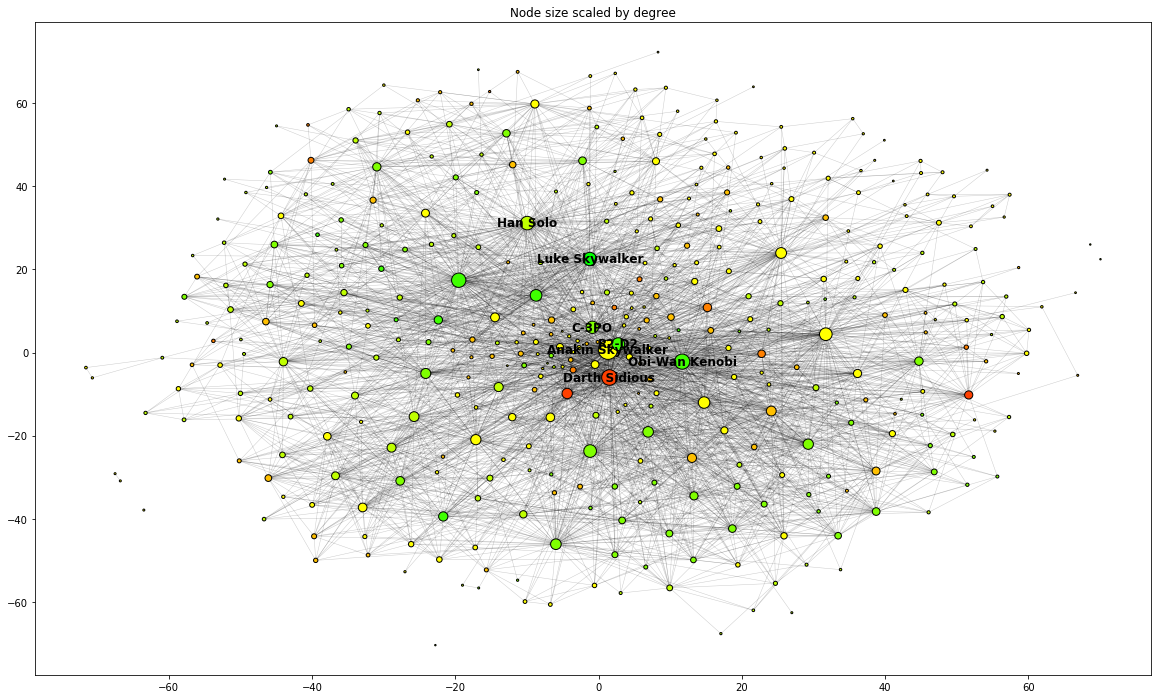

In [4]:
# Drawing the graph
plt.figure(figsize=(20,12))
plt.title("Node size scaled by degree")


# Creating the colorscale according to goodness
red = 255
green = 0
stepSize = 64 
colorScale = []
while green < 255 :
    green += stepSize
    if green > 255 : 
        green = 255
    colorScale.append(('#%02x%02x%02x' % (red, green, 0)))

while(red > 0) :
    red -= stepSize
    if red < 0 :
        red = 0
    colorScale.append(('#%02x%02x%02x' % (red, green, 0)))

# Setting up datastructure used for the drawing    
sizemap_degree = []    
colormap = []
for node in G_undir:
    sizemap_degree.append(G.degree(node, weight="weight") + 2)
    idx = G.node[node]['goodness']+3
    colormap.append(colorScale[idx])

nodelist = [node for node in G_undir.nodes]
edgelist = [edge for edge in G_undir.edges]

# Adding labels for the most important characters
labelNodes = ["Anakin Skywalker", "Obi-Wan Kenobi", "R2-D2", "C-3PO", "Darth Sidious", "Luke Skywalker", "Han Solo"]
labels = {}
for node in nodelist :
    if node in labelNodes :
        labels[node] = node
    else :
        labels[node] = ""

# Drawing the nodes, edges and selected labels
nx.draw_networkx_nodes(G_undir, positions, with_labels=False, nodelist=nodelist, node_color=colormap, edgecolors="black", node_size=sizemap_degree)
nx.draw_networkx_edges(G_undir, positions, alpha=0.2, edge_color="black", width=0.5, edgelist=edgelist)
nx.draw_networkx_labels(G_undir,pos=positions, labels = labels, font_color = "black", font_weight = "bold")
plt.show()

### Analysis step 1.1 : Centrality measurements
 
#### Explain what you're interested in
We're interested in measuring the centrality of all of the Star wars characters, in order to get an idea of the most important characters. We will do this using three different centrality measures: Degree centrality, betweenness centrality and eigenvector centrality.
 
#### Explain the tool
_Degree centrality_ is nice

_Betweenness centrality_ also nice

_Eigenvector centrality_ most nice

#### Apply the tool
 
#### Discuss the outcome

### Analysis step 1.2 : Community detection
 
#### Explain what you're interested in
For this step we wish to analyze our network to see if we can find any communities. And if so how to fit with the actual affiliations between the characters such as family, race, movie or alliance. Or see if we find some communities which are not obvious from the movies.
 
#### Explain the tool
For this we will be using the Louvain algorithm to find the communities. The way this algorithm works is by trying to maximize the modularity, which is a measurement of how many links are between the nodes in the community compare to between the different communities. We are going to use the built-in algorithm from the community library.
 
#### Apply the tool

Value of modularity: 0.369215820677


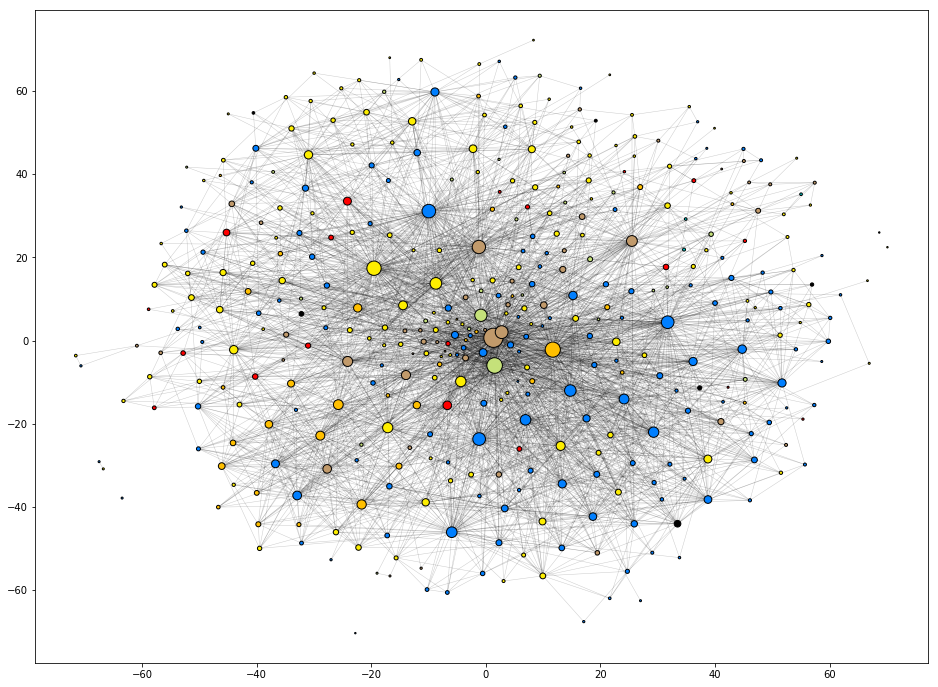

In [5]:
# Applying the algorithm
partition = community_louvain.best_partition(G_undir)
print("Value of modularity: %s" % community_louvain.modularity(partition, G_undir))

# Extracting the communities to separate lists
communities = []
for com in set(partition.values()):
    list_nodes = [node for node in partition.keys()
                                if partition[node] == com]
    if len(list_nodes) > 1:
        communities.append(list_nodes)
        
# Sort the communities based on nodedegree    
comDegrees = []
for com in communities :
    comDegreeSorted = sorted(com, key=lambda x: G.degree(x), reverse=True)
    comDegrees.append(comDegreeSorted)  
    
# Set colors for communities
rColors = []
rColors.append("#007FFF")
rColors.append("#C19A6B")
rColors.append("#FFBF00")
rColors.append("#FDEE00")
rColors.append("#FF0000")
rColors.append("#C5E17A")
rColors.append("#000000")
rColors.append("#00CCCC")
rColors.append("#000000")
rColors.append("#000000")
rColors.append("#000000")
rColors.append("#000000")
rColors.append("#000000")
rColors.append("#000000")

# Create colormap for graph
colormap = []
for node in G_undir:
    for i in range(len(communities)):
        com = communities[i]
        if node in com:
            colormap.append(rColors[i])
            break
            
# Draw the network
plt.figure(1, figsize=(16, 12)) 
light_gray = '#d3d3d3'
nx.draw_networkx_nodes(G_undir, positions, with_labels=False, nodelist=nodelist, node_color=colormap, edgecolors="black", node_size=sizemap_degree)
nx.draw_networkx_edges(G_undir, positions, alpha=0.2, edge_color="black", width=0.5, edgelist=edgelist)

plt.show()

#### Discuss the outcome

In [9]:
for com in comDegrees :
    print com[:15]
    print len(com)

['Darth Sidious', 'Obi-Wan Kenobi', 'Ahsoka Tano', 'Padm\xc3\xa9 Amidala', 'Dooku', 'Rex', 'Yoda', 'Maul', 'Mace Windu', 'Grievous', 'Asajj Ventress', 'Qui-Gon Jinn', 'Plo Koon', 'Jar Jar Binks', 'Nute Gunray']
136
['Anakin Skywalker', 'Jabba Desilijic Tiure', 'Boba Fett', 'Bossk', 'Dengar', 'Black Krrsantan', 'BT-1', 'Cylo', 'Cassio Tagge', 'Sebulba', 'IG-88', '0-0-0', 'Dodd Rancit', 'Karbin', '4-LOM']
43
['Wilhuff Tarkin', 'Ezra Bridger', 'Kanan Jarrus', 'Bail Organa', 'Hera Syndulla', 'Sabine Wren', 'C1-10P', 'Hondo Ohnaka', 'Garazeb Orrelios', 'Alexsandr Kallus', 'CC-3636', 'Jan Dodonna', "Mitth'raw'nuruodo", 'Cham Syndulla', 'AP-5']
34
['Leia Organa', 'Han Solo', 'Luke Skywalker', 'Chewbacca', 'Mon Mothma', 'Lando Calrissian', 'Wedge Antilles', 'Poe Dameron', 'Gial Ackbar', 'Finn', 'Kylo Ren', 'Rey', 'BB-8', 'Maz Kanata', 'Temmin Wexley']
136
['Greedo', 'Jyn Erso', 'Cornelius Evazan', 'Galen Walton Erso', 'Nuvo Vindi', 'Cassian Jeron Andor', 'K-2SO', 'Bodhi Rook', 'Ponda Baba', 'L

From the communities we can see that they have been clustered into some general groups. The first community containing characters like Ahsoka Tano, Dooku, Padmé Amidala, Mace Windu, Qui-Gon Jinn and Grievous. These are all characters who are only part of the Episodes 1-3 and The Clone Wars animated series, which is what seems to be captured by this community. It however also contains characters like Darth Sidious and Obi-Wan Kenobi, which are also part of the Episodes 4-6.

The second community contains characters like Anakin, Jabba, Boba Fett, Bossk and Sebulba. What seems to be in common here is the connections to the planet of Tatooine, which is where Jabba has his gangster empire and Anakin and Sebulba are native too.

The third has characters like Ezra, Kana, Hera and C1-10P which are all from the animated series Star Wars Rebels.

The fourth community consist of characters like Leia, Han, Luke and Chewbacca, but also Poe, Kylo and Rey. So what seems to be caugth by this community is the Episodes 4-8, which make alot of sense since most of the cast from 4-6 also play a part in episode 7 and 8.

The next community contains characters like Jyn Erso, Galen Erso, Cassian Andor, K-2SO and Chirrut which are part of the main cast of the Rogue One movie.

For the sixth community we have R2-D2, C-3PO, Owen Lars, Shmi Skywalker, Beru Lars and Cliegg Lars. This is a bit more difficult to match as most of these are in family, and local to Tatooine, but then we have the two droid, which only have a weak connection to these.

The last communities seems to capture some famlies. The Naberries and Panzoro, and in the last The Smuggler and Riley are brother and sister, which are hires by Dapp according to Wookiepedia.

We see that it seems the community detection algorithm mostly found the communities based on which movies or family they belong to. 

As for the modularity for the communities, we get a value of 0.37, this is not a very high value, which when looking at the communities is most likely due to many of the characters span across multiple movies and therefore will have a lot of edges to other characters in other communities. Also the node with the highest degree Anakin Skywalker, most definitely has connections to alot of the nodes in the other communities as the indegree, and outdegree is 212 and 156, but the size of the community is only 43, meaning most of the edges to and from this nodes goes betweem communities and thereby influences the modularity in a negative way.



### Analysis step 1.3 : Race sentiment analysis
 
#### Explain what you're interested in
We thought that it might be interesting to analyze the Wookieepedia pages for the characters using sentiment analysis. This way we could see if a bad sentiment score also matched a character which is evil, but instead of doing this for all of the characters we decided that we would instead do it based on the races of the character to see, if it is the races which makes characters evil or good.
 
#### Explain the tool
For this we will use the sentiment score dataset, which we were introduced to in the course. This dataset contain a list of word, which all have an associated score based on the ratings from how good/happy to bad/evil/sad the word is. We can use these scores to calculate an average sentiment value for an article, by adding all of the score for all of the words in the article and dividing by the number of words. This will give us an idea to how positive or negative the articles word use is. As the list does not contain all possible words only the ones in the list will be counted, and when calculating the average, we will only divide with the number of words which had a sentiment score.
#### Apply the tool

In [29]:
# Defining functions needed for calculating sentiment scores        
def tokenize(text):
    text = text.decode('ascii','ignore')

    # Remove all punctuation and numbers
    regexp = '[^\W]+'
    cleanTokens = re.findall(regexp, text)
    
    # Remove all words of length 1 and set lowercase
    cleanTokens = [w.lower() for w in cleanTokens if len(w) > 1]
    stopwords = nltk.corpus.stopwords.words('english')

    # Remove stopwords
    cleanTokens = [w for w in cleanTokens if w not in stopwords]
    
    return cleanTokens

def read_file(filename):
    with io.open('./'+filename, encoding='utf-8') as f:
        return f.read()

# Read word list and extract all the various categories
mt_word_list = read_file('Sentiment_Data_Set_S1.txt').splitlines()[3:]
sentiment_dict = {}

# Iterating over every word in list
for row in mt_word_list[1:]:
    cols = row.split("\t")
    word = cols[0]
    # cols[2] is the happiness score avg.
    sentiment_dict[word] = cols[2]

def get_sentiment(tokens):
    sentiment_sum = 0.0
    count = 0
    for token in tokens:
        if token in sentiment_dict:
            sentiment_sum += float(sentiment_dict[token]) # happiness avg
            count += 1
    if count == 0:
        return None
    avg_hap = sentiment_sum / float(count)
    return avg_hap


('gossam', 5.0815312500000065)


NameError: name 'sortSentiment' is not defined

In [30]:
# Extracting the members of each species
species = {}
for node in G.nodes :
    spe = G.nodes[node]["species"]
    if spe in species :
        species[spe].append(node)
    else :
        species[spe] = [node]

# Caculating the sentiment score for each species
speciesSentiment = {}
for spe in species.keys() :
    speciesSentiment[spe] = 0
    for name in species[spe]:
        fileName = name.replace(" ", "_") + ".txt"
        text = open("./Wookiepediafiles/" + fileName, "r").read()
        speciesSentiment[spe] += get_sentiment(tokenize(text))
    speciesSentiment[spe] = speciesSentiment[spe]/len(species[spe]) 

# Sorting and printing the species with lowest and highest sentiment score    
sortedSentiment = sorted(speciesSentiment.items(), key=lambda kv: kv[1])
print sortedSentiment[0]
print sortedSentiment[-1]

('gossam', 5.0815312500000065)
('bith', 5.699873417721526)


#### Discuss the outcome
We see that the sentiment scores does not differ to much with the lowest being the gossam with a score of 5.08 and the highest being the bith with a score of 5.7. When taking a closer look into these two species we might understand why they are in the bottom and top of this list. 

The characters of the bith species is mostly known for being the band playing music in the cantinas of the movies. This makes sense as for them to be among the highest scoring in sentiment, as music and happiness often is connected, and thereby resulting in a high sentiment score. When looking in the opposite side of the list we find the Gossam. This species have members such as Shu Mai. This name might not seem familar, but when looking into who it is the lower score starts making sense. This is a member of the seperatist, which are the bad guys during the Clone Wars and Episodes 1-3, which makes sense as to why a lower score of sentiment is resulting. We dont have any other members of the race in of list, but when looking on Wookieepedia all of the 4 members listed to be of this species all are part of the seperatist, making all of the species seem evil.

We see that the human race has a score of 5.36, which is in the middle of the list. This is most likely due to the number of good and evil character of the species canceling out each other score and thereby ending up very average eventhough the evilest and good-est characters both are of this race.

So eventhough we got an evil race as having the lowest sentiment score, using sentiment score to predict if a race is good or evil does not seem like it is going to work, as sentiment is more of a happy/sad scale than a good/evil scale, which we saw with the top scoring race being the musicians of the cantinas, eventhough these does not seem to being either good or evil. 

### Preprocessing step 2:

In [12]:
# Regular expression returning the tuple (index, character, dialogue) for each line
def getInfo(str_in):
    grouped = re.findall('"(.*)" "(.*)" "(.*)"', str_in)
    if len(grouped) == 0:
        return None
    return grouped[0]

# For each line in the dialogue, add the line to the characther dict
def getCharacterDictFromFile(file_name):
    df = pd.read_fwf(file_name)
    lines = []
    for i in df['"character" "dialogue"']:
        lines.append(getInfo(i))
    character_dict = {}
    for line in lines:
        if line is None:
            continue
        if line[1] in character_dict:
            character_dict[line[1]].append(line)
        else :
            character_dict[line[1]] = [line]
    return character_dict

character_dictIV = getCharacterDictFromFile('./Transcripts/SW_EpisodeIV.txt')
character_dictV = getCharacterDictFromFile('./Transcripts/SW_EpisodeV.txt')
character_dictVI = getCharacterDictFromFile('./Transcripts/SW_EpisodeVI.txt')

### Analysis step 2 : The Transcripts - talking distribution and wordclouds
 
#### Explain what you're interested in
We find it interesting to look into the dialog of the original movies. We wish to investigate which characters are the most talkative, and what words are the most "saying" for the different movies.
 
#### Explain the tool
In order to find the most talkative character from the triology, we perform a simple count for every character in the dialogue_dict that was generated for every movie through the preprocessing.   

In the generation of the individual movie-wordclouds we build upon TF-IDF as defined below: 
\\[ tf(t,d) = \dfrac{f_{t, d}}{\mid d_u \mid} \qquad f_{t,d} = \text{the frequency of t in d} \qquad d_u = \text{Unique words in d} \\  idf(term, documents) = \log \left( \dfrac{N}{\mid \left\{ document \in documents : term \in document \right\} \mid}  \right) \\
tfidf(t, d, D) = tf(t, d) \cdot idf(t, D) \\]
Before inputting our data into the TF-IDF, we removed punctionation and stopwords and words with length <= 1. 
 
#### Apply the tool

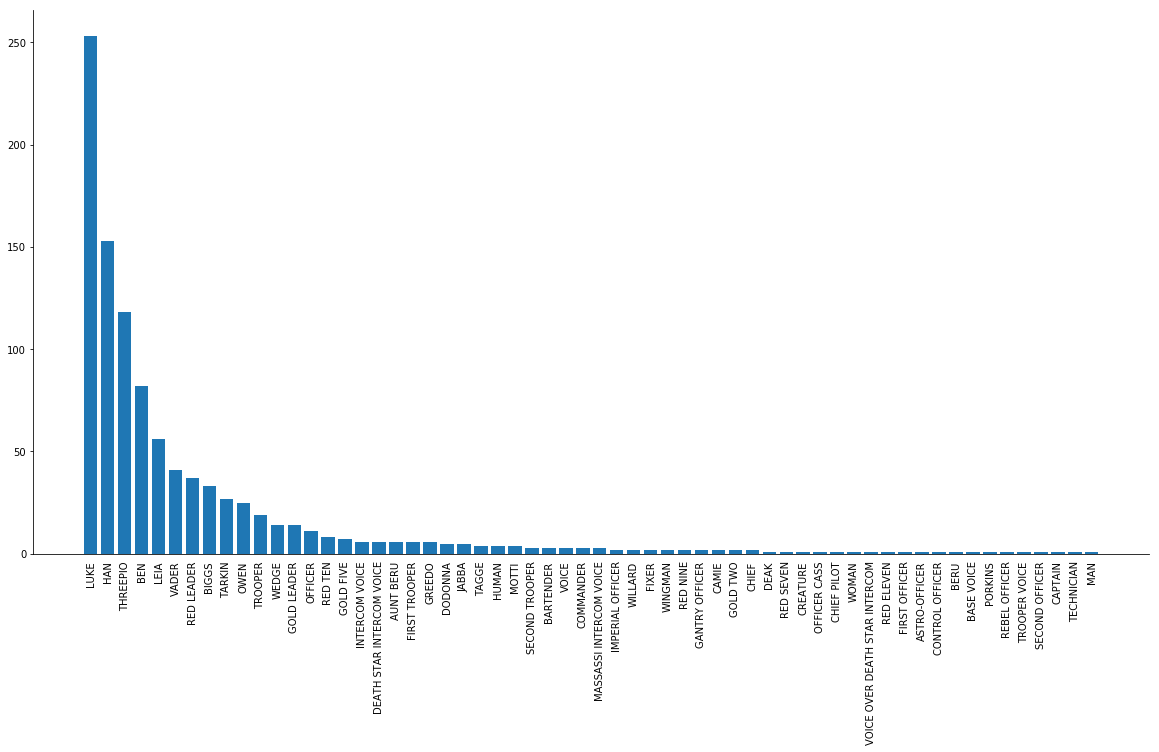

In [13]:
# Generating a sorted list of characters and how much they talk.
def getCharacterTalk(character_dict):
    character_talk = {}
    for character in character_dict:
        character_talk[character] = len(character_dict[character])
    sorted_character_talk = sorted (character_talk.items(), key=lambda x: x[1], reverse=True)
    return sorted_character_talk

# Generating the list for the three movies
character_talkIV = getCharacterTalk(character_dictIV)    
character_talkV = getCharacterTalk(character_dictV)    
character_talkVI = getCharacterTalk(character_dictVI)    

# Plotting the sorted number of lines for each character in a bar-plot, enabling us to quickly spot the result. 
# The image is then saved to a folder to make it easy for us to update the webpage.
def drawTalkPlot(talk, name):
    x = []
    y = []
    for i in talk:
        x.append(i[0])
        y.append(i[1])

    plt.figure(figsize = (20,10))
    plt.title("")
    plt.bar(x,y)
    plt.xticks(rotation=90)
    i = 0
    for spine in plt.gca().spines.values():
        if i % 2 == 1:
            spine.set_visible(False)
        i += 1
    plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
    plt.rcParams.update({'figure.autolayout': True})
    plt.rcParams.update({'font.size': 12})
    plt.savefig("docs/img/"+name+".png", transparent=True)
    plt.show()

# Executing the method, actually generating the plots and saving them to files for easy update of the 
drawTalkPlot(character_talkIV, "talk_alot_iv")
#drawTalkPlot(character_talkV, "talk_alot_v")
#drawTalkPlot(character_talkVI, "talk_alot_vi")

We then move on to the wordcloud generation:

/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


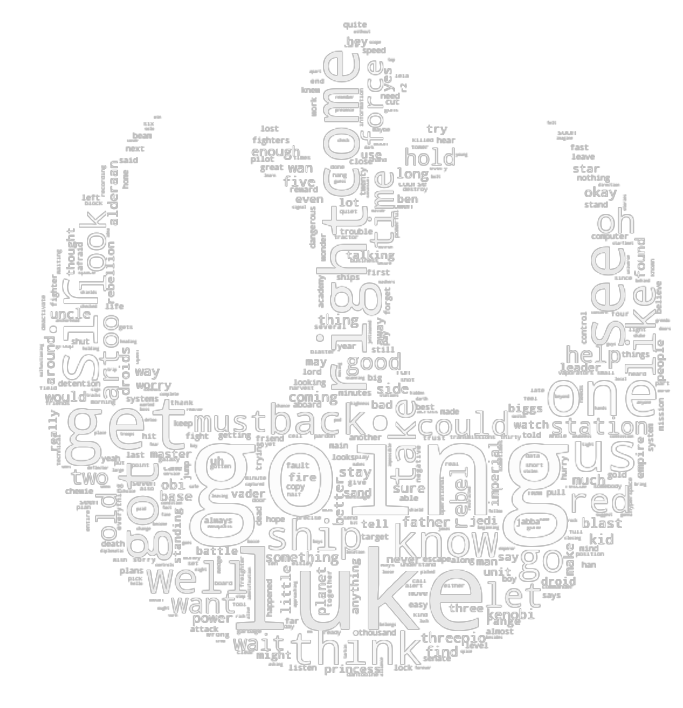

In [14]:
# Returning a oneliner for a given dialogue_dict. Simply a oneliner of all dialogue in the movie.
def oneLiner(character_dict):
    one_list_to_rule_them_all = []
    for char in character_dict:
        for line in character_dict[char]:
            one_list_to_rule_them_all.append(line[2])
    return " ".join(one_list_to_rule_them_all)

def tf_idf(doc1, docs):
    # TF
    fd = nltk.FreqDist(doc1) # We utilize the nltk to easily get the frequency of 
    sorted_tokens = [x[0] for x in fd.most_common()]
    tf = np.array([(float(x[1]) / len(fd)) for x in fd.most_common()])


    # IDF
    dem_sets = [set(doc1)]
    for doc in docs:
        dem_sets.append(set(doc))
       
    df = np.array([sum([t in s for s in dem_sets]) for t in sorted_tokens])    
    idf = np.log((len(docs)+1) / df)
    
    tf_dict = {}
    for i in range(len(sorted_tokens)):
        tf_dict[sorted_tokens[i]] = tf[i] * idf[i]
    return tf_dict

# Grey colors, used as the colorfunction in our wordcloud in order to ensure that the words are visible on colorful backgrounds.
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(90, 100)

def generate_wordcloud(doc, docs, name):
    doc_tokens = tokenize(doc)
    docs_tokens = tokenize(" ".join(docs))
    tfidf = tf_idf(doc_tokens, docs_tokens)
    
    r2_mask = np.array(Image.open('./Transcripts/rebel.png', 'r'))
    wordcloud = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA" ,max_words=2000, mask=r2_mask)

    wordcloud.generate_from_frequencies(tfidf)
    
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3), interpolation="bilinear")
    plt.axis("off")
    
    plt.rcParams.update({'figure.autolayout': True})
    plt.savefig("docs/img/"+name+".png", transparent=True)

    plt.show()
    
textIV = oneLiner(character_dictIV)
textV = oneLiner(character_dictV)
textVI = oneLiner(character_dictVI)

generate_wordcloud(textIV, [ textV, textVI], "word_cloud_iv")
#generate_wordcloud(textV, [textIV, textVI], "word_cloud_v")
#generate_wordcloud(textVI, [textIV, textV], "word_cloud_vi")

#### Discuss the outcome
From our results we see that C3PO talks a surprising amount when comparing him to the other character of the series. Especially it is interesting that he talks so much more than the charachters we first think of when we talk about Star Wars (Luke, Han, Vader).

From the wordclouds we also run into surprises, we did not expect to meet going as one of the most "siginificant" *WE NEEED A BETTER WORD* words. When looking into the dialogue we however see that going is mentioned 62 times in Star Wars Episode 4, but only 41 in episode 5 and 6 combined, the words is as shown by the wordcloud overrepresented by "A New Hope". Furthermore, we see that names are also heavily represented, showing that the dialogue indicates who the important characters are.

### Analysis step 2.1 : Sentiment for dialogue (+ scripts)
 
#### Explain what you're interested in
As mentioned above, we find it interesting to look into the dialogue of the original triology. We want to further investigate the sentiment of the dialogue. 
* Can we see an evolution throughout the series in certain characters? Does the sentiment of Darth Vader show that he is turning to the light?
* Can we spot scenes from the sentiment alone?
* Can we from the sentiment guess if a character is "good" or "evil"?
 
#### Explain the tool
To investigate this, we look into the use of sentiment though sentiment lists (to be shown below) and tokenization as shown above. We utilize the same preprocessed data in our quest for information (and spoilers).

#### Apply the tool

In [15]:
# Given a characther and the character_dict(dialogue), we can return a list of indexed of when the characther spoke, 
# as well as the lines he spoke. We can then get sentiment for the individual sentances and get an idea of the "moment"
def getSentimentsForCharacter(character, character_dict):
    time = []
    sentiments = []
    if character not in character_dict:
        return None
    c = character_dict[character]
    for line in c:
        tokens = tokenize(line[2])
        sentiment = get_sentiment(tokens)
        if(sentiment) is None:
            continue
        time.append(int(line[0]))
        sentiments.append(sentiment)
    return time, sentiments

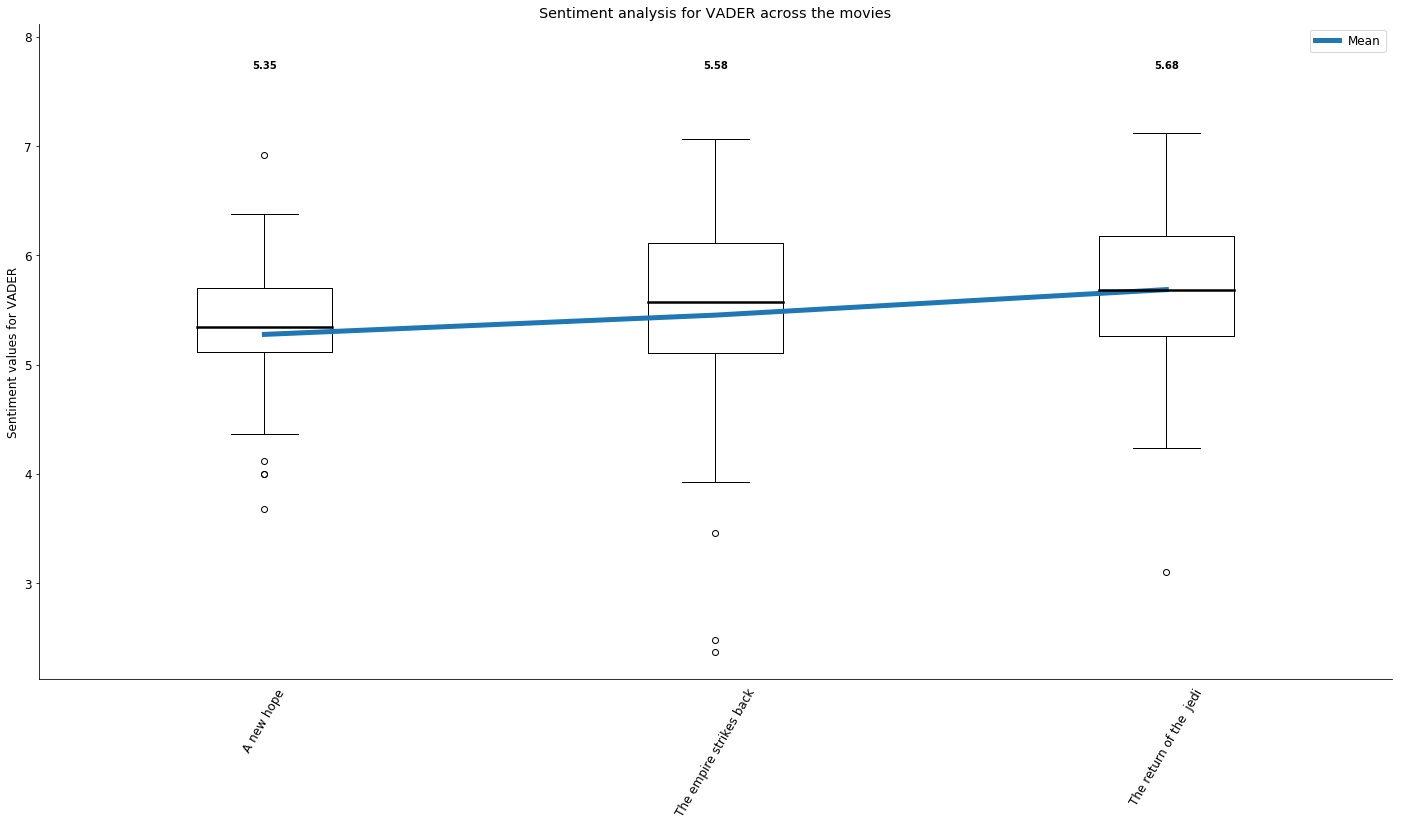

In [16]:
def characterSentimentAcrossMovies(char, list_of_dicts, movie_names, name):
    fig, ax1 = plt.subplots(figsize=(20, 12))
    ax1.set_axisbelow(True)
    ax1.set_title("Sentiment analysis for " + char + " across the movies")
    ax1.set_ylabel("Sentiment values for "+ char)
    
    top = 0
    bottom = 100
    data = [] 
    for char_dict in list_of_dicts:
        d = getSentimentsForCharacter(char, char_dict)[1]
        if top < max(d):
            top = max(d)
        if bottom > min(d):
            bottom = min(d)
        data.append(d)
    bp = ax1.boxplot(data)
    ax1.set_xticklabels(movie_names, rotation=60)
    
    plt.setp(bp['medians'], color="black")
    plt.setp(bp['medians'], linewidth=2.5)
        
    top = top + 1
    bottom = bottom - 0.25
    ax1.set_ylim(bottom, top)
    
    medians = [np.median(a) for a in data]
    pos = np.arange(len(list_of_dicts)) + 1
    upperLabels = [str(np.round(s, 2)) for s in medians]
    weights = ['bold', 'semibold']
    for tick, label in zip(range(len(list_of_dicts)), ax1.get_xticklabels()):
        k = tick % 2
        ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
                 horizontalalignment='center', size='small', weight="bold",
                 color="black")
        
    i = 0
    for spine in plt.gca().spines.values():
        if i % 2 == 1:
            spine.set_visible(False)
        i += 1
    plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
    
    d1 = [i+1 for i in range(len(list_of_dicts))]
    d2 = [np.mean(a) for a in data]
    plt.plot(d1, d2, linewidth= 5, label="Mean", color="#1f77b4")  
    plt.legend()
    plt.rcParams.update({'font.size': 24})
    plt.rcParams.update({'figure.autolayout': True})
    plt.savefig("docs/img/"+name+".png", transparent=True)

    plt.show()  
characterSentimentAcrossMovies("VADER", [character_dictIV, character_dictV, character_dictVI], ["A new hope", "The empire strikes back", "The return of the  jedi"], "VADER_sentiment")

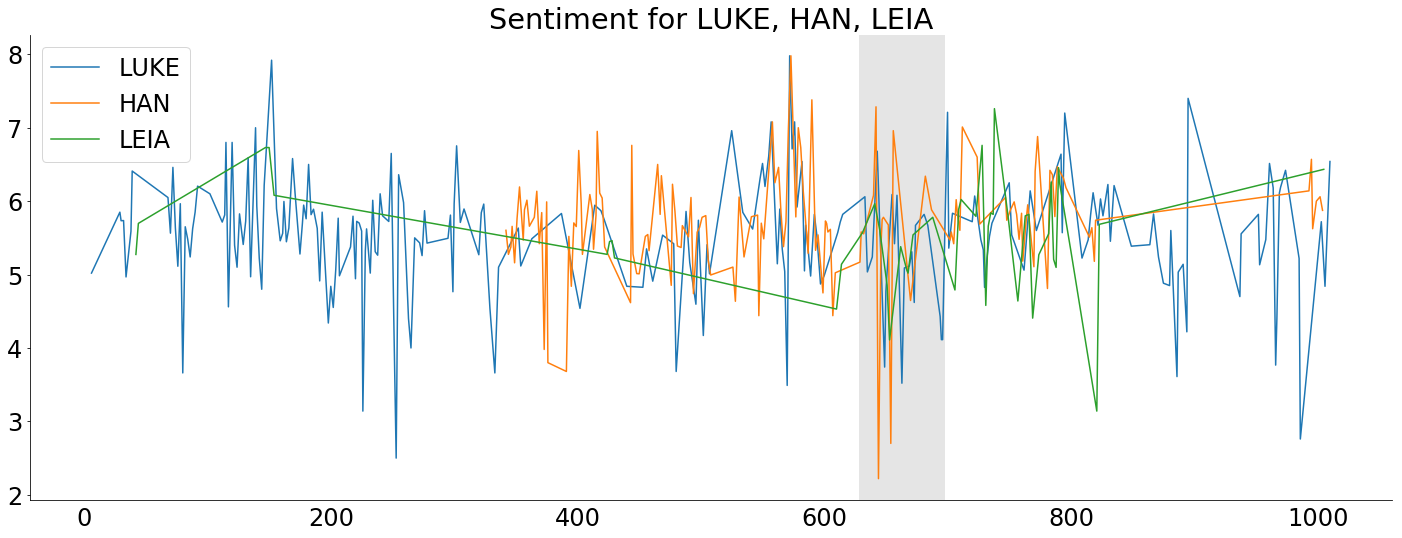

In [17]:
def drawSentimentForCharacters(chars, character_dict):
    plt.figure(figsize=(20,8))
    plt.title("Sentiment for " + ", ".join(chars))
    for char in chars:
        x, y = getSentimentsForCharacter(char, character_dict);
        plt.plot(x,y)
    plt.axvspan(628, 698, facecolor='0.5', alpha=0.2)
    plt.legend(chars)
    i = 0
    for spine in plt.gca().spines.values():
        if i % 2 == 1:
            spine.set_visible(False)
        i += 1
    plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
    
    plt.show()
drawSentimentForCharacters(["LUKE", "HAN", "LEIA"], character_dictIV)

#### Discuss the outcome

### Analysis step 3: The scripts
 
#### Explain what you're interested in
 
* Is there a difference between the sentiment of the dialogue and the script?
* Can we "see" the storyline from the sentiment of the scripts?

 
 #### Explain the tool
 
 #### Apply the tool
 
 #### Discuss the outcome

 ## Discussion 
 

    What went well?,
    What is still missing? What could be improved?, Why?
